__Les analyses étant fortement liées au cleaning, ce notebook contient aussi mes analyses univariées/bivariées/pca__\
Par soucis de respect des consignes, j'ai copié mes analyses dans un autre notebook, mais ce sont les mêmes que dans celui ci

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from deep_translator import GoogleTranslator
import string
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
import spacy 
import time
import unicodedata
from rapidfuzz import process

In [2]:
nlp_fr = spacy.load('fr_core_news_sm')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maximedupouy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

calcul du nutriscore bien expliqué \
https://quoidansmonassiette.fr/comment-est-calcule-le-nutri-score-logo-nutritionnel/#:~:text=Ce%20score%20est%20bas%C3%A9%20sur,le%20sel%20(mg%2F100g) \
https://www.kaggle.com/ananyaroy1011/food-calorie-classification

# Load Data

In [3]:
df = pd.read_csv('./fr.openfoodfacts.org.products.csv', sep='\t' )

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.shape

(320772, 162)

In [5]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploration data

In [6]:
# pourcentage de nan
df.isnull().sum().sum()/df.size

0.7622157263195134

In [7]:
def get_dataframe_info(df):
    """
    input
       df -> DataFrame
    output
       df_null_counts -> DataFrame Info (sorted)
    """

    df_types = pd.DataFrame(df.dtypes)
    df_nulls = df.count()
    
    df_null_count = pd.concat([df_types, df_nulls], axis=1)
    df_null_count = df_null_count.reset_index()
    
    # Reassign column names
    col_names = ["features", "types", "non_null_counts"]
    df_null_count.columns = col_names
    
    # Add this to sort
    df_null_count = df_null_count.sort_values(by=["non_null_counts"], ascending=False)
    
    return df_null_count

In [8]:
df.info(verbose=True, show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 162 columns):
 #    Column                                      Non-Null Count   Dtype  
---   ------                                      --------------   -----  
 0    code                                        320749 non-null  object 
 1    url                                         320749 non-null  object 
 2    creator                                     320770 non-null  object 
 3    created_t                                   320769 non-null  object 
 4    created_datetime                            320763 non-null  object 
 5    last_modified_t                             320772 non-null  object 
 6    last_modified_datetime                      320772 non-null  object 
 7    product_name                                303010 non-null  object 
 8    generic_name                                52795 non-null   object 
 9    quantity                                    104819 non-nu

In [9]:
df_info  = get_dataframe_info(df)
df_info.head(10)

,features,types,non_null_counts
5,last_modified_t,object,320772
6,last_modified_datetime,object,320772
2,creator,object,320770
3,created_t,object,320769
4,created_datetime,object,320763
0,code,object,320749
1,url,object,320749
58,states_fr,object,320726
57,states_tags,object,320726
56,states,object,320726


In [10]:
list(df.main_category_fr.unique())

[nan,
 'Filet-de-boeuf',
 'Légumes frais',
 'Pâtisseries',
 'Pains',
 'Boulange',
 'Aliments et boissons à base de végétaux',
 'Root-bier',
 'Sablés',
 'Plats préparés',
 'Volailles',
 'Bonbons',
 'Thés',
 'Sirops',
 'en:Chicken-feet',
 'Desserts',
 'Gâteaux',
 'Sodas',
 'Condiments',
 'Sodas aux fruits',
 'Compléments alimentaires',
 'Viandes',
 'Chips et frites',
 'Epices',
 'Produits à tartiner',
 'Poissons et viandes et oeufs',
 'Pate-au-foie-de-canard',
 'Cookies',
 'Plats à base de viande',
 'Epicerie',
 'Soupes',
 'en:Carrot-coriander-soup',
 'Champignons',
 'en:Scottish-shortbread',
 'en:Charcuteries',
 'Chocolats',
 'en:Tuna-steaks',
 'Boissons',
 'Fruits',
 'Sandwichs',
 'en:Pear-and-blackcurrant-juice',
 'Farines',
 'Conserves',
 'Yaourts',
 'Huiles',
 'en:Harengs',
 'Confitures',
 'Fromages de vache',
 'Pâtes alimentaires',
 'it:Vinaigre-balsamique',
 'en:Parve',
 'Pickles',
 'en:Lindt-sea-salt-chocolate',
 'en:Pates-a-tartiner-aux-noisettes-et-au-cacao',
 'Pâtes à tartiner

In [11]:
#je sépare les colonnes en fonction de leur type de données
columns = df.columns.to_list()
columns_float = [column for column in columns if df[column].dtype=='float64']
columns_object = [column for column in columns if df[column].dtype=='O']

In [12]:
#je regarde si j'ai toutes les colonnes
len(columns_object) + len(columns_float) == len(columns)

True

## Colonnes qualitatives

In [13]:
df['nutrition_grade_fr'].isnull().sum()

99562

In [14]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [15]:
def make_pie_chart(column):
    plt.style.use('seaborn-notebook')
    count_unique = pd.DataFrame(df[column].value_counts()).reset_index() 
    plt.figure(figsize=(8,8))
    plt.pie(count_unique.iloc[:20, 1], labels = count_unique.iloc[:20, 0])
    plt.title(f"Camenbert des 20 {column} les plus fréquents");

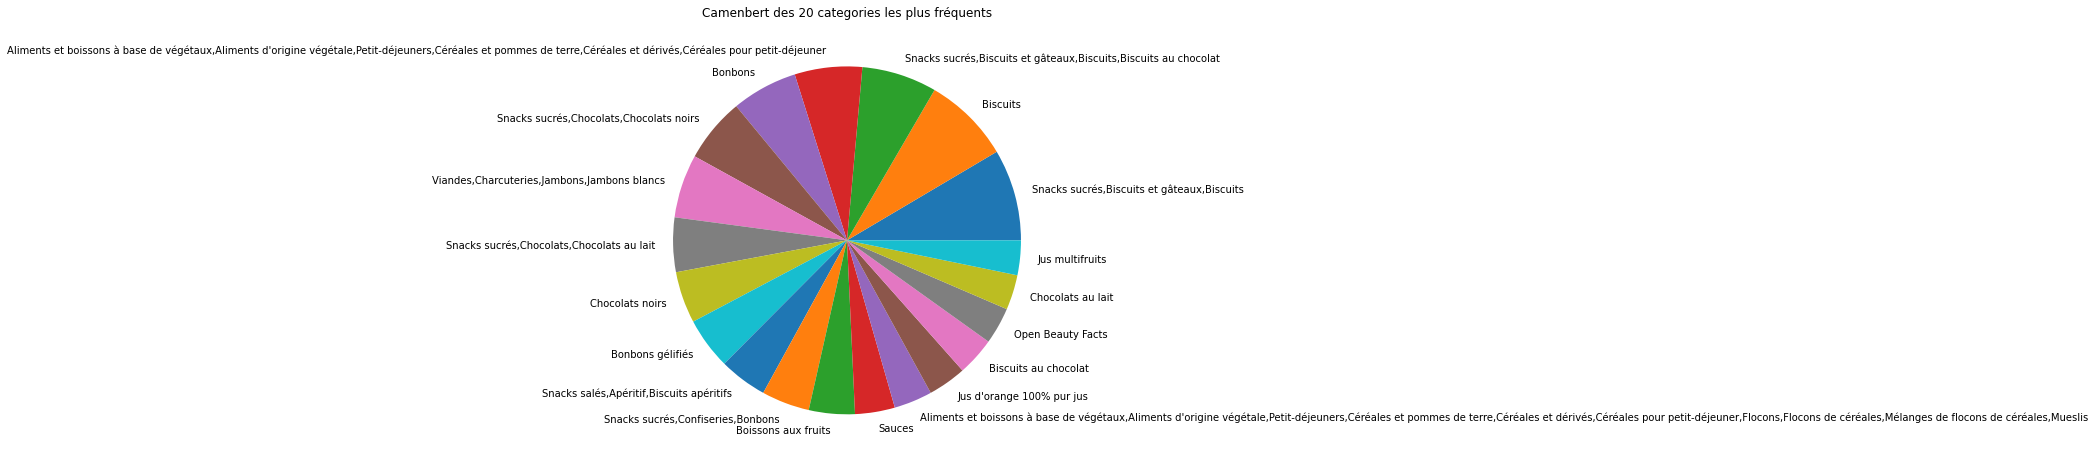

In [16]:
make_pie_chart('categories')

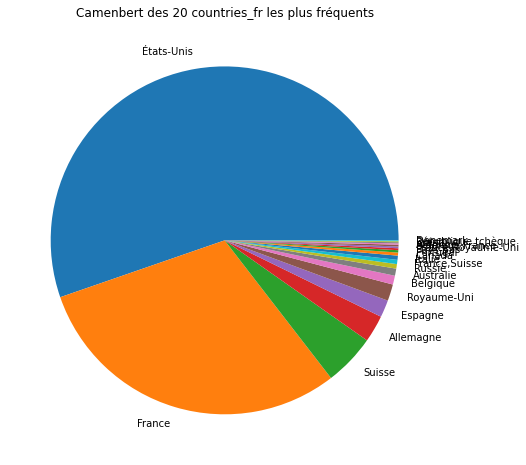

In [17]:
make_pie_chart('countries_fr')

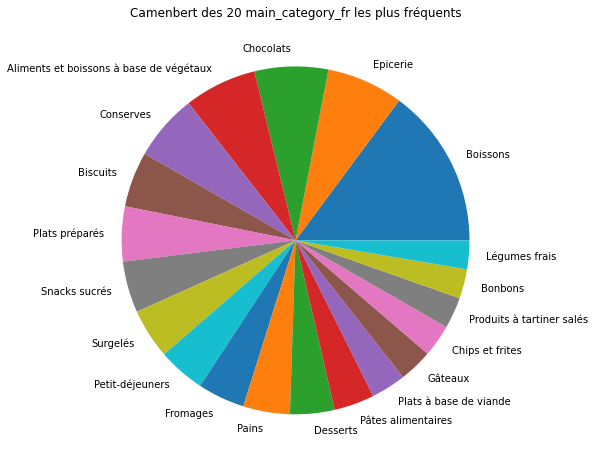

In [18]:
make_pie_chart('main_category_fr')

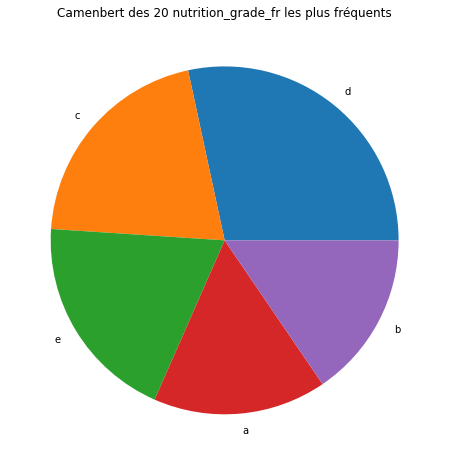

In [19]:
make_pie_chart('nutrition_grade_fr')

In [20]:
! pip install wordcloud

You should consider upgrading via the '/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


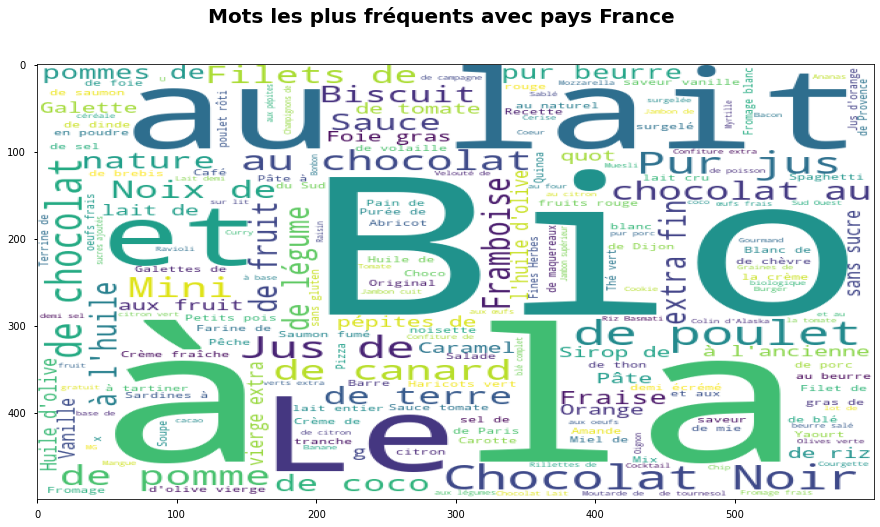

In [21]:
from wordcloud import WordCloud
df_ = df[~(df['product_name'].isna())&(df['countries_fr']=='France')]
wordcloud = WordCloud(width=600, height=500, background_color='white').generate(' '.join(df_['product_name']))
WordCloud.generate_from_frequencies


fig, ax1 = plt.subplots(1,1, figsize=(15,8))

fig.suptitle('Mots les plus fréquents avec pays France', weight='bold', fontsize=20)
# Display image, `aspect='auto'` makes it fill the whole `axes` (ax3)
im1 = ax1.imshow(wordcloud, aspect='auto')

plt.show()

# Selection grossiere des features

Premiere sélection apide des colonnes et lignes ques je vais utiliser. Il y aura une autre séléction lorsque j'aurai avancé sur l'analyse

## Selection colonnes

Je vais enlever les colonnes présentant moins de 1000 valeurs non nulles dans un premier temps

In [22]:
columns_selected = df_info['features'][df_info['non_null_counts']>1000].to_list()
len(columns_selected)

95

In [23]:
df_info[df_info.types=='object']

,features,types,non_null_counts
5,last_modified_t,object,320772
6,last_modified_datetime,object,320772
2,creator,object,320770
3,created_t,object,320769
4,created_datetime,object,320763
0,code,object,320749
1,url,object,320749
58,states_fr,object,320726
57,states_tags,object,320726
56,states,object,320726


In [24]:
columns_numeric_selected=['nutrition-score-fr_100g',
                            'proteins_100g',#effet rénal
                            'sodium_100g',#mauvais tension 
                            'salt_100g',#mauvais tension 
                            'fat_100g',#mauvais coeur
                            'saturated-fat_100g',#mauvais coeur
                            'cholesterol_100g',#mauvais coeur
                            'trans-fat_100g',#mauvais coeur 
                          'polyunsaturated-fat_100g', #bon pour coeur
                        'monounsaturated-fat_100g', #bon pour coeur
                            'carbohydrates_100g',#mauvais diabete
                        'sugars_100g',#mauvais diabete
                        'alcohol_100g'#mauvais pour tous
    
]

In [25]:
columns_object_selected =[
    'code',
    'product_name',
    'main_category_fr',
    'main_category',
    'nutrition_grade_fr',
    'countries_fr',
    'ingredients_text'
]

In [26]:
columns_selected = columns_object_selected+columns_numeric_selected

In [27]:
df = df[columns_selected]

In [28]:
df.shape

(320772, 20)

## selection des lignes

Je vais faire une séléction en fonction des pays ! pour cela, je vais voir le % de null à chaque ajout de pays

In [29]:
countries_list = df.countries_fr.value_counts().index.to_list()[:25]
countries_list.remove('France')
df_france = df[df['countries_fr']=='France']
add_coutry =['France']
for country in countries_list:
    add_coutry.append(country)
    df_ = df[df['countries_fr'].isin(add_coutry)]
    add_coutry.append(country)
    print(country, df_.isnull().sum().sum()/df_.size)

États-Unis 0.3617188376528666
Suisse 0.3702668385616077
Allemagne 0.3735945667492497
Espagne 0.37571827302843286
Royaume-Uni 0.38001963025792623
Belgique 0.38295791727519646
Australie 0.38495756453931435
Russie 0.38620532461039236
France,Suisse 0.3860622255782995
Italie 0.38732890257740316
Canada 0.38825992926830843
Portugal 0.38859608660309924
Pays-Bas 0.3890010303635251
France,Royaume-Uni 0.3892668861143614
Belgique,France 0.38924713410955214
Autriche 0.389642118759516
Brésil 0.3899968300828341
République tchèque 0.3903677399747269
Danemark 0.3906298147923206
Hongrie 0.39082778908099025
France,Allemagne 0.39078247326275745
Thaïlande 0.39110540968915736
France,États-Unis 0.3910688107894502
Allemagne,Suisse 0.39102692305242576


Il ne semble pas y avoir de pays qui rajoute énormement de valeur ni de pays qui en enleve beaucoup.
Par soucis de simpliciter, je vais garder les pays européens anglophones, français et espagne (qui rajoute un peu de data)

In [30]:
df[~df['main_category_fr'].isna()]['countries_fr'].value_counts()[:10]

France           58752
Allemagne         6066
Espagne           3891
Royaume-Uni       2487
États-Unis        1711
Suisse            1711
Australie         1148
France,Suisse      898
Russie             845
Belgique           821
Name: countries_fr, dtype: int64

In [31]:
selected_coutries = ['France','Italie', 'Suisse', 'Allemagne', 'Espagne', 'Royaume-Uni', 'Belgique', 'France,Suisse',
                    'Belgique,France']

In [32]:
df_selected_coutries = df[df['countries_fr'].isin(selected_coutries)]

In [33]:
df_selected_coutries.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132593 entries, 0 to 320770
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   code                      132593 non-null  object 
 1   product_name              118130 non-null  object 
 2   main_category_fr          75439 non-null   object 
 3   main_category             75439 non-null   object 
 4   nutrition_grade_fr        77683 non-null   object 
 5   countries_fr              132593 non-null  object 
 6   ingredients_text          71605 non-null   object 
 7   nutrition-score-fr_100g   77683 non-null   float64
 8   proteins_100g             83312 non-null   float64
 9   sodium_100g               79799 non-null   float64
 10  salt_100g                 79845 non-null   float64
 11  fat_100g                  66836 non-null   float64
 12  saturated-fat_100g        79421 non-null   float64
 13  cholesterol_100g          440 non-null     f

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_1743/3750531307.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df_selected_coutries.info(verbose=True,null_counts=True)


In [34]:
df_selected_coutries.shape

(132593, 20)

In [35]:
df_selected_coutries.isnull().sum().sum()/df_selected_coutries.size

0.5079879782492288

In [36]:
df_selected_coutries.product_name.sample(20)

264122                                      Paprika-Chili
186720                                      Mozard-Kugeln
187407                                            Nutella
208315      Beurre de baratte demi-sel au sel de Guérande
312813                                                NaN
290840                                      Pain aux noix
233894                             Crème Normande Épaisse
280387                                     Coca Cola Life
280112                                       Indian Curry
218838                           Échalote coupée surgelée
223940    Chambolle-Musigny 1er Cru Les Feusselottes 2008
279367                                  Coles de Bruselas
247018                                       Sugar Flakes
196803                     Calendrier de l'Avent Nativité
262799                                       Maiskölbchen
196701     Biscuits apéritif Apéro Cracks fins & fondants
297660                                       Gruyère rapé
305372        

# Cleaning des catégories

Ma méthode pour rezmplir les na est la suivante : je veux faire un fill na sur la médiane par catégorie (par exemple \si il manque le taux de sel des chips vico, je rempli par la moyenne de la catégorie chips)\
Le but de ce cleaning est double :
- clean un maximum les catégories des produits afin de les diminuer pour pouvoir faire un fill na pertinent
- arriver à faire un modele de classfication en catégorie si il me mauqne la donnée pour ne pas perdr de la donnée

## Data Cleaning

### Traduction

In [37]:
#premier data cleaning sur du texte en vu de traduire
tqdm.pandas()

def remove_2_points(row):
    try :
        if ':' in row :
            return ' '.join([i for i in row.split(':')][1:])
        else :
            return row
    except :
        return row
def remove_tiret(row):
    try :
        if '-' in row :
            return ' '.join(row.split('-'))
        else :
            return row
    except :
        return row
def strip_words(row):
    try :
        row = ' '.join(i.strip() for i in row.split())
        return row
    except :
        return row

def translate(sentence):
    try :
        sentence_trad = GoogleTranslator(source='auto', target='en').translate(sentence)
        return sentence_trad
    except :
        return sentence

In [38]:
# lit le dataset déja traduit, sinon lance mon preprocessing [long ++++++]
try :
    df_translated = pd.read_csv('./dataset_translated.csv')
except :
    df_selected_coutries['main_category'] = df_selected_coutries['main_category'].apply(
        lambda x : remove_2_points(x)).apply(
        lambda x : remove_tiret(x)).apply(
        lambda x : strip_words(x))
    df_selected_coutries['product_name'] = df_selected_coutries['product_name'].apply(
        lambda x : remove_2_points(x)).apply(
        lambda x : remove_tiret(x)).apply(
        lambda x : strip_words(x))
    df_selected_coutries['main_category']=df_selected_coutries['main_category'].progress_apply(
    lambda x :  translate(x))
    df_selected_coutries['product_name']=df_selected_coutries['product_name'].progress_apply(
    lambda x :  translate(x))
    df_selected_coutries.to_csv('./dataset_translated.csv', index=True)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
df_translated.drop(columns='Unnamed: 0', inplace=True)

In [40]:
df_translated['product_name_original']=list(df_selected_coutries['product_name'])

In [41]:
df_translated.head()

,code,product_name,main_category_fr,main_category,nutrition_grade_fr,countries_fr,ingredients_text,nutrition-score-fr_100g,proteins_100g,sodium_100g,...,fat_100g,saturated-fat_100g,cholesterol_100g,trans-fat_100g,polyunsaturated-fat_100g,monounsaturated-fat_100g,carbohydrates_100g,sugars_100g,alcohol_100g,product_name_original
0,3087,Black wheat flour,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Farine de blé noir
1,24600,Cut of beef,Filet-de-boeuf,cut of beef,NaN,France,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Filet de bœuf
2,27083,Marks % Spencer 2 Blueberry Muffins,NaN,NaN,NaN,Royaume-Uni,pasteurized free range egg.sugar.blueberries (...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marks % Spencer 2 Blueberry Muffins
3,27205,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,39259,Twix x2,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twix x2


### Clean variable catégorie

In [42]:
def remove_upper_case(row:str)->str:
    '''take a sentence, put char in lower and return sentence'''
    return row.lower()

def remove_punctuation(row:str)->str:
    '''take a sentence, remove punctuation and return sentence'''
    for punctuation in string.punctuation:
        row= row.replace(punctuation, ' ').strip(' ')
    return row

def remove_number(row:str)->str:
    '''take a sentencde and return sentence without digit'''
    return ''.join([char for char in row if char.isdigit()==False])

def remove_accents(row:str)->str:
    '''take a sentrcne and remove accent'''
    nfkd_form = unicodedata.normalize('NFKD', row)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

def remove_stop_words(row:str)->list:
    '''take a sentence, remove stop words and return a tokenise sentence'''
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(row)
    row = [w for w in word_tokens if not w in stop_words]
    return row

def lemmatize_french(row:list)->list:
    row = nlp_fr(row)
    row_lemmatized = [word.lemma_ for word in row]
    return row_lemmatized

def lemmatize(row:list)->list:
    lemmatizer = WordNetLemmatizer()
    row_lemmatized = [lemmatizer.lemmatize(word) for word in row]
    return row_lemmatized

def stemming(row:list)->list:   
    stemmer = PorterStemmer()
    row_stem = [stemmer.stem(word) for word in row]
    return row_stem

def stemming_french(row:list)->list:
    fr = SnowballStemmer('french')
    row_stem = [fr.stem(word) for word in row]
    return row_stem

In [43]:
#je m'interesse dans un premier temps que au dataset ou la catégorie est présente
df_categories_without_nan = df_translated[(~df_translated['main_category'].isna())]
len(df_categories_without_nan)

75439

In [44]:
df_categories_without_nan.countries_fr.value_counts()

France             58752
Allemagne           6066
Espagne             3891
Royaume-Uni         2487
Suisse              1711
France,Suisse        898
Belgique             821
Belgique,France      462
Italie               351
Name: countries_fr, dtype: int64

In [45]:
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
tqdm.pandas()
df_categories_without_nan['main_category']=df_categories_without_nan['main_category'].apply(
    lambda x : remove_upper_case(x)).apply(
    lambda x : remove_punctuation(x)).apply(
    lambda x : remove_number(x)).apply(
    lambda x : remove_accents(x)).apply(
    lambda x : remove_stop_words(x))
df_categories_without_nan['main_category_lemmatize'] = df_categories_without_nan[
    'main_category'].progress_apply(lambda x : lemmatize(x))
df_categories_without_nan['main_category_stemmed'] = df_categories_without_nan[
    'main_category'].progress_apply(lambda x : stemming(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maximedupouy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/maximedupouy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75439/75439 [00:02<00:00, 30651.64it/s]


In [46]:
df_categories_without_nan['main_category_lemmatize'] = df_categories_without_nan['main_category_lemmatize'].apply(lambda x : ' '.join(x))
df_categories_without_nan['main_category_stemmed'] = df_categories_without_nan['main_category_stemmed'].apply(lambda x : ' '.join(x))

In [47]:
#check la difference entre lemmatize et stemmatize
print(len(df_categories_without_nan['main_category_lemmatize'].unique()))
print(len(df_categories_without_nan['main_category_stemmed'].unique()))

2057
2036


Je pars sur le stemming !

In [48]:
count_classes = pd.DataFrame(df_categories_without_nan['main_category_stemmed'].value_counts())
print(f"taille dataset de départ {count_classes['main_category_stemmed'].sum()}")
print(f"nombre de catégories unique {len(count_classes['main_category_stemmed'])}")
classes_les_plus_fréquentes = count_classes[count_classes['main_category_stemmed']>100]
classes_les_moins_fréquentes = count_classes[count_classes['main_category_stemmed']<=100]
print(f"taille dataset en supprimant les classes les moins fréquentes {classes_les_plus_fréquentes['main_category_stemmed'].sum()}")
print(f"nombre de catégories unique restantes {len(classes_les_plus_fréquentes['main_category_stemmed'])}")

taille dataset de départ 75439
nombre de catégories unique 2036
taille dataset en supprimant les classes les moins fréquentes 70814
nombre de catégories unique restantes 111


In [49]:
count_classes

,main_category_stemmed
beverag,5337
groceri,2503
chocol,2440
plant base food beverag,2434
can food,2376
...,...
anchoiad,1
batteri juic,1
pure butter cooki,1
pouss germe,1


In [50]:
#permet d'eassayer de matcher les categories à la mano afin d'en réduire les classes
def closest_sentence(category, serie, score_min, remove=False):
    choices = list(serie.unique())
    if remove :
        choices.remove(category)
    similitude = process.extract(category, choices, limit=2)
    best_score = similitude[0][1]
    if best_score>=score_min :
        print(category, similitude)

In [51]:
classes_les_plus_fréquentes=classes_les_plus_fréquentes['main_category_stemmed'].reset_index()

In [52]:
#affiche parmi les classes les plus fréquentes celle se ressemblant le plus (objectif reduction potencielle nombre de classe)
classes_les_plus_fréquentes[
    'index'].apply(lambda x : closest_sentence(x, classes_les_plus_fréquentes['index'], 90, remove=True))

beverag [('plant base food beverag', 90.0, 2), ('tea', 60.00000000000001, 55)]
chocol [('chocol dessert', 90.0, 64), ('cooki', 54.54545454545454, 73)]
plant base food beverag [('beverag', 90.0, 0), ('can food', 85.5, 3)]
meal [('meal meat', 90.0, 13), ('meat', 75.0, 28)]
sugari snack [('sugar', 90.0, 61), ('salti snack', 78.26086956521739, 22)]
chees [('french chees', 90.0, 32), ('cow chees', 90.0, 43)]
dessert [('chocol dessert', 90.0, 64), ('plant base food beverag', 51.42857142857142, 3)]
bread [('bread product', 90.0, 49), ('breakfast', 80.0, 11)]
meal meat [('meal', 90.0, 5), ('meat', 90.0, 28)]
salt spread [('spread', 90.0, 29), ('salt', 90.0, 82)]
salti snack [('salt', 90.0, 82), ('sugari snack', 78.26086956521739, 8)]
milk [('whole milk yogurt', 90.0, 69), ('veget oil', 60.00000000000001, 57)]
fruit [('fruit juic', 90.0, 42), ('dri fruit', 90.0, 50)]
yogurt [('fruit yogurt', 90.0, 52), ('whole milk yogurt', 90.0, 69)]
meat [('meal meat', 90.0, 14), ('prepar meat', 90.0, 47)]
sp

0      None
1      None
2      None
3      None
4      None
       ... 
106    None
107    None
108    None
109    None
110    None
Name: index, Length: 111, dtype: object

In [53]:
to_repechage_1={
'herbal tea': 'tea',
'squeez orang juic':'orang juic',
'green tea': 'tea',
'pari ham': 'ham',
'stir yogurt': 'yogurt'}

Je vais regarder dans les classes les moins fréquentes si j''ai des classes qui peuvent être intégrées aux classes les plus fréquentes

In [54]:
classes_les_moins_fréquentes=classes_les_moins_fréquentes['main_category_stemmed'].reset_index()

In [55]:
#affiche parmi les classes les mpoins fréquentes celle ressemblant à des clases plus fréquentes
classes_les_moins_fréquentes[
    'index'].apply(lambda x : closest_sentence(x, classes_les_plus_fréquentes['index'], 91))

ice cream tea [('ice cream', 95.0, 38), ('cream', 90.0, 49)]
fruit juic nectar [('fruit nectar', 95.0, 61), ('fruit', 90.0, 27)]
sandwitch [('sandwich', 94.11764705882352, 36), ('sand', 90.0, 89)]
wheatflour [('wheat flour', 95.23809523809523, 91), ('flour', 90.0, 94)]
diatari supplement [('dietari supplement', 94.44444444444444, 78), ('nut', 72.0, 34)]
yogurt piec fruit [('fruit yogurt', 95.0, 53), ('fruit', 90.0, 27)]
concentr juic [('concentr fruit juic', 95.0, 101), ('orang juic', 60.86956521739131, 108)]
bbiscuit [('biscuit', 93.33333333333333, 6), ('fruit', 67.5, 27)]
raw prepar meat [('prepar meat', 95.0, 48), ('meat', 90.0, 29)]
fruit juic concentr [('concentr fruit juic', 95.0, 101), ('fruit', 90.0, 27)]
fruit juic mix [('fruit juic', 95.0, 43), ('fruit', 90.0, 27)]
juic concentr [('concentr fruit juic', 95.0, 101), ('nut', 60.00000000000001, 34)]
fruit juic fruit [('concentr fruit juic', 95.0, 101), ('fruit', 90.0, 27)]
rice cream [('ice cream', 94.73684210526316, 38), ('rice

0       None
1       None
2       None
3       None
4       None
        ... 
1920    None
1921    None
1922    None
1923    None
1924    None
Name: index, Length: 1925, dtype: object

In [56]:
# classe peu fréquentes que je vais remplacer par des plus fréqeuntes pour grapiller de la data
to_repechage = {
    'ice cream tea' :'beverage',
    'bbiscuit' :'biscuit',
    'diatari supplement':'dietari supplement',
    'fruit juic nectar': 'fruit nectar',
    'wheatflour': 'wheat flour',
    'yogurt piec fruit' :'fruit yogurt',
    'concentr juic' :'concentr fruit juic',
    'raw prepar meat' :'prepar meat',
    'fruit juic concentr' :'concentr fruit juic',
    'fruit juic mix' :'fruit juic',
    'juic concentr' :'concentr fruit juic',
    'fruit juic fruit' :'concentr fruit juic'
}

In [57]:
to_repechage.update(to_repechage_1)

In [58]:
df_categories_without_nan['main_category_stemmed']=df_categories_without_nan[
    'main_category_stemmed'].apply(lambda x : to_repechage.get(x, x))

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [59]:
#je séléctionne la donnée avec les catégories dont le nombre de produits est supérieur à 100
count_classes = pd.DataFrame(df_categories_without_nan['main_category_stemmed'].value_counts())
classes_les_plus_fréquentes = count_classes[count_classes['main_category_stemmed']>100]
df_categories_without_nan = df_categories_without_nan[
    df_categories_without_nan['main_category_stemmed'].isin(list(classes_les_plus_fréquentes.index))]
print(df_categories_without_nan.shape)
print(df_categories_without_nan.main_category_stemmed.nunique())

(70831, 23)
106


### Cleaning product name

In [60]:
#je rempli les product_name par la catégorie si il n'y a pas de catégorie
df_categories_without_nan['product_name'].fillna(value=df_categories_without_nan['main_category_stemmed'], inplace=True)

In [61]:
# du datacleaning classique
df_categories_without_nan['product_name_clean'] = df_categories_without_nan['product_name'].apply(
    lambda x : remove_upper_case(x)).apply(
    lambda x : remove_punctuation(x)).apply(
    lambda x : remove_number(x)).apply(
    lambda x : remove_accents(x)).apply(
    lambda x : remove_stop_words(x)).progress_apply(
    lambda x : stemming(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70831/70831 [00:04<00:00, 17434.98it/s]


In [62]:
df_categories_without_nan['product_name_clean'] = df_categories_without_nan['product_name_clean'].apply(lambda x : ' '.join(x))
df_categories_without_nan['product_name_clean'].head(3)

8                             flute
11                     green lentil
13    shortbread biscuit cocoa fill
Name: product_name_clean, dtype: object

In [63]:
print(f"taille dataset complet {len(df_categories_without_nan)}")
print(f"taille dataset category null {df_categories_without_nan['main_category_stemmed'].isnull().sum()}")
print(f"taille dataset product name null {df_categories_without_nan['product_name_clean'].isnull().sum()}")

taille dataset complet 70831
taille dataset category null 0
taille dataset product name null 0


## classification supervisée sur categorie

Objectif : réaliser une classification supervisée pour catégoriser les produits qui n'ont pas de catégorie afin de faire mon fill na dessus

In [64]:
REDO=True

### prepare Data

In [65]:
X = df_categories_without_nan['product_name_clean'].to_list()
y = df_categories_without_nan['main_category_stemmed']

In [66]:
#séléctionne la data qui n'a pas de catégory ou qui a des catégories 'outliers" dans mon dataset de "base"
df_selected_no_category = df_translated[(df_translated.main_category_fr.isna())&(~df_translated.product_name.isna())]
df_selected_no_category.main_category_fr.unique()

array([nan], dtype=object)

In [67]:
# du datacleaning classique
df_selected_no_category['product_name_clean'] = df_selected_no_category['product_name'].apply(
    lambda x : remove_upper_case(x)).apply(
    lambda x : remove_punctuation(x)).apply(
    lambda x : remove_number(x)).apply(
    lambda x : remove_accents(x)).apply(
    lambda x : remove_stop_words(x)).progress_apply(
    lambda x : stemming(x))
df_selected_no_category['product_name_clean'] = df_selected_no_category['product_name_clean'].apply(lambda x : ' '.join(x))
df_selected_no_category['product_name_clean'].head(3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43463/43463 [00:02<00:00, 18332.96it/s]


0                black wheat flour
2    mark spencer blueberri muffin
4                           twix x
Name: product_name_clean, dtype: object

In [68]:
to_predict = pd.DataFrame(df_selected_no_category['product_name_clean'].str.split(expand=True).stack().value_counts())
training_set = pd.DataFrame(df_categories_without_nan['product_name_clean'].str.split(expand=True).stack().value_counts())

### baseline

In [69]:
from sklearn.dummy import DummyClassifier


dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.0753483644167102

### TFIDF

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Je fais un tfidf en gardant que 1000 mots.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer(max_features=1000)
tf_idf_vectorizer.fit(X)
X_train_tfidf=tf_idf_vectorizer.transform(X_train)
X_test_tfidf = tf_idf_vectorizer.transform(X_test)
X_train_tfidf= X_train_tfidf.toarray()
X_train_data = pd.DataFrame(X_train_tfidf,columns = tf_idf_vectorizer.get_feature_names())
X_train_data.head()

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acacia,acid,activia,ad,agav,age,agen,al,alaska,albacor,...,xxl,yeast,yellow,yoghurt,yogurt,yop,yoplait,young,zero,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
#je viens summer sur l'axe 1 les valeurs associées aux mots afin de séléctionner uniquement les observations ayant une fréquence de mot suffisantes
X_train_data['sum']=X_train_data.sum(axis=1)
X_train_data['y_label']=list(y_train)
X_train_data=X_train_data[X_train_data['sum']>1]
X_train_data.head()

,acacia,acid,activia,ad,agav,age,agen,al,alaska,albacor,...,yellow,yoghurt,yogurt,yop,yoplait,young,zero,zucchini,sum,y_label
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.723178,cooki
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.983766,meal
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.397827,farm product
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712548,dessert
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.990159,meal meat


In [73]:
# % de data qu'il reste
print(len(X_train_data)/len(X_train_tfidf))

0.7828093391773432


In [74]:
# je fais la même méthode sur X_test
x_test_ = pd.DataFrame(X_test_tfidf.toarray(),columns = tf_idf_vectorizer.get_feature_names())
x_test_['sum']=x_test_.sum(axis=1)
x_test_['y_label']=list(y_test)
x_test_=x_test_[x_test_['sum']>1]

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [75]:
# % de data qu'il reste
print(len(x_test_)/len(X_test_tfidf.toarray()))

0.7770267379679144


In [76]:
X_train_2=X_train_data.drop(columns=['sum', 'y_label'])
y_train_2 = X_train_data['y_label']

x_test_2=x_test_.drop(columns=['sum', 'y_label'])
y_test_2=x_test_['y_label']

### Logistic regression

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
if REDO :
    clf = LogisticRegression(random_state=0, max_iter=1000, C=4).fit(X_train_2, y_train_2, )
    y_pred = clf.predict(x_test_2)
    print(f1_score(y_test_2, y_pred, average='micro'))
    print(f1_score(y_test_2, y_pred, average= 'macro'))

0.713153113472444
0.7020984325821944


### Gridsearch

In [78]:
from sklearn.model_selection import GridSearchCV

if REDO :
    # Instanciate model
    model = LogisticRegression(max_iter=1000)
    # Hyperparameter Grid
    grid = {'C': [0.1, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 10.0]}
    # Instanciate Grid Search
    search_linear = GridSearchCV(model, grid,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs=-1)

    # Fit data to Grid Search
    linear_gridsearch = search_linear.fit(X_train_2, y_train_2)
    print(linear_gridsearch.best_params_)

{'C': 4.0}


### Logistic regression sur dataset

In [79]:
X_tfidf=tf_idf_vectorizer.transform(X)

X_tfidf= X_tfidf.toarray()
word_tfidf = pd.DataFrame(X_tfidf,columns = tf_idf_vectorizer.get_feature_names())
word_tfidf.head()

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acacia,acid,activia,ad,agav,age,agen,al,alaska,albacor,...,xxl,yeast,yellow,yoghurt,yogurt,yop,yoplait,young,zero,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
#meme méthode que au dessus
word_tfidf['sum']=word_tfidf.sum(axis=1)
word_tfidf['y_label']=list(y)
word_tfidf=word_tfidf[word_tfidf['sum']>1]

In [81]:
df_selected_no_category['product_name_clean']

0                                        black wheat flour
2                            mark spencer blueberri muffin
4                                                   twix x
5         extren chocolatey milk dark white chocol biscuit
6                                   diet lemonad sainsburi
                                ...                       
132583                                         test nf app
132584                                              almond
132586                                                leek
132589                                chees cake vert yuzu
132592                                   vermicelli tomato
Name: product_name_clean, Length: 43463, dtype: object

In [82]:
df_selected_ = df_selected_no_category[~df_selected_no_category['product_name_clean'].isna()]
df_selected_.reset_index(inplace=True)
to_pred_tfidf=tf_idf_vectorizer.transform(list(df_selected_['product_name_clean']))

In [83]:
to_pred = pd.DataFrame(to_pred_tfidf.toarray(),columns = tf_idf_vectorizer.get_feature_names())
to_pred.head()

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acacia,acid,activia,ad,agav,age,agen,al,alaska,albacor,...,xxl,yeast,yellow,yoghurt,yogurt,yop,yoplait,young,zero,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
to_pred['sum']=to_pred.sum(axis=1)
to_pred=to_pred[to_pred['sum']>1]
len(to_pred)

28643

In [85]:
df_selected_=df_selected_[df_selected_.index.isin(list(to_pred.index))]

In [86]:
X_word_tfidf=word_tfidf.drop(columns=['sum', 'y_label'])
y_word_tfidf=word_tfidf['y_label']

In [87]:
clf = LogisticRegression(random_state=0, max_iter=1000, C=4).fit(X_word_tfidf, y_word_tfidf)

In [88]:
to_pred=to_pred.drop(columns='sum')
y_label_pred = clf.predict(to_pred)

In [89]:
df_selected_['cat_pred']=list(y_label_pred)

In [90]:
df_selected_.sample(10)

,index,code,product_name,main_category_fr,main_category,nutrition_grade_fr,countries_fr,ingredients_text,nutrition-score-fr_100g,proteins_100g,...,cholesterol_100g,trans-fat_100g,polyunsaturated-fat_100g,monounsaturated-fat_100g,carbohydrates_100g,sugars_100g,alcohol_100g,product_name_original,product_name_clean,cat_pred
38646,118388,80008590,Natural mineral water with low mineral content,NaN,NaN,NaN,Italie,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Acqua Minerale Naturale Oligominerale,natur miner water low miner content,water
12065,45432,3269617090133,Duck terrine with figs Jean Brunet verrine,NaN,NaN,e,France,NaN,20.0,12.4,...,NaN,NaN,NaN,NaN,NaN,0.7,NaN,Terrine de canard aux figues Jean Brunet verrine,duck terrin fig jean brunet verrin,terrin
5652,17462,3038354527000,Unbeatable Long Grain Rice,NaN,NaN,a,France,NaN,-2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,0.5,NaN,Riz Long Grain Incollable,unbeat long grain rice,rice
23481,85684,4012824401228,good night,NaN,NaN,NaN,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bonne nuit,good night,tea
26897,95385,5050083210044,Special K dark chocolate,NaN,NaN,c,Suisse,"Riz(40%), Blé complet(29%), Chocolat(17%)(Sucr...",8.0,8.7,...,NaN,NaN,NaN,NaN,74.0,18.0,NaN,Special K choco noir,special k dark chocol,breakfast
21360,79659,3760121212580,butter churn,NaN,NaN,e,France,NaN,27.0,0.7,...,NaN,NaN,NaN,NaN,NaN,0.6,NaN,Beurre de baratte,butter churn,butter
25698,91867,4622420821278,melting hearts,NaN,NaN,NaN,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cœurs fondants,melt heart,can food
17765,66757,3560071015350,Organic Milk Chocolate Rice Cakes,NaN,NaN,d,France,NaN,17.0,7.8,...,NaN,NaN,NaN,NaN,NaN,27.0,NaN,Galettes bio riz chocolat au lait Bio,organ milk chocol rice cake,plant base food beverag
21023,78423,3760059740056,Vine Peach Nectar,NaN,NaN,b,France,NaN,2.0,0.4,...,NaN,NaN,NaN,NaN,NaN,12.0,NaN,Nectar De Peche De Vigne,vine peach nectar,fruit nectar
14052,52622,3335880006048,Catalan Ratatouille,NaN,NaN,NaN,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ratatouille à la Catalane,catalan ratatouil,meal


In [91]:
df_selected_['numeric_nan']=df_selected_[['nutrition-score-fr_100g', 'proteins_100g', 'sodium_100g', 'salt_100g',
       'fat_100g', 'saturated-fat_100g', 'cholesterol_100g', 'trans-fat_100g',
       'polyunsaturated-fat_100g', 'monounsaturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'alcohol_100g']].isnull().sum(axis=1)

In [92]:
data_to_add = df_selected_[df_selected_['numeric_nan']<13]

### Embedding

__NON FONCTIONNEL__

X_train_list_list=[]
X_test_list_list=[]
for elem in X_train :
    X_train_list_list.append(list(elem.split()))
for elem in X_test :   
    X_test_list_list.append(list(elem.split()))

corpus = list(df_translated_[~df_translated_['product_name_clean'].isna()]['product_name_clean'])
corpus_list=[]
for elem in corpus :
    corpus_list.append(list(elem.split()))

from gensim.models import Word2Vec
word2vec = Word2Vec(sentences=corpus_list, window=2, min_count=1)

word2vec.wv.most_similar('andalusi')

a = [len(x) for x in corpus_list]
max(a)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten


def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
    return np.array(embedded_sentence)


def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed


X_train_embed = embedding(word2vec, X_train_list_list)
X_test_embed = embedding(word2vec, X_train_list_list)

# Fill na

Remplir les valeurs manquantes en utilisaant une méthode par catégorie

## Check les outliers

In [93]:
data_to_add.drop(columns=['numeric_nan',  'index'],inplace=True)
data_to_add=data_to_add.rename(columns={'cat_pred':'main_category_stemmed'})
data_to_add['main_category_fr']=data_to_add['main_category_stemmed']

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [94]:
print(df_categories_without_nan.shape)
df_categories_without_nan=pd.concat([df_categories_without_nan,data_to_add], axis=0)
print(df_categories_without_nan.shape)

(70831, 24)
(88292, 24)


In [95]:
def make_boxplot(data, col):
    data_without_nan = data[col][~data[col].isna()]
    sns.boxplot(data_without_nan);
    plt.title(f'boxplot de la colonne {col}')
    plt.show()

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


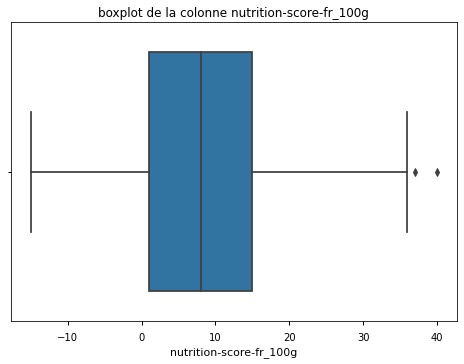

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


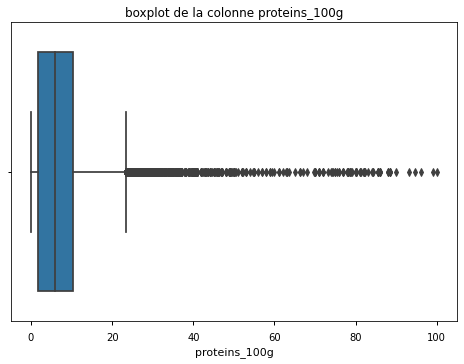

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


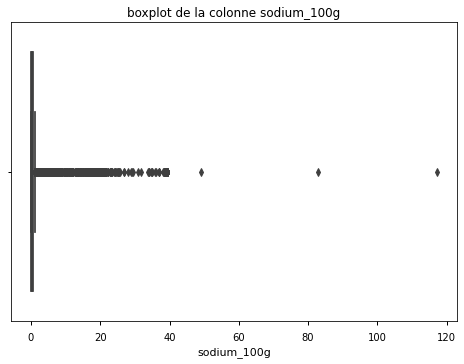

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


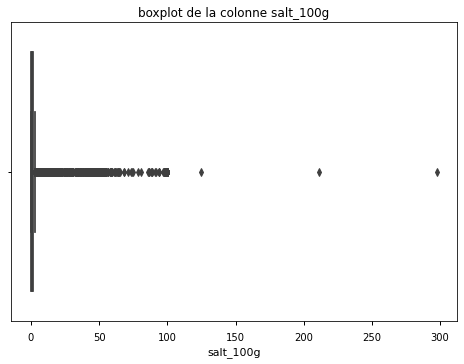

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


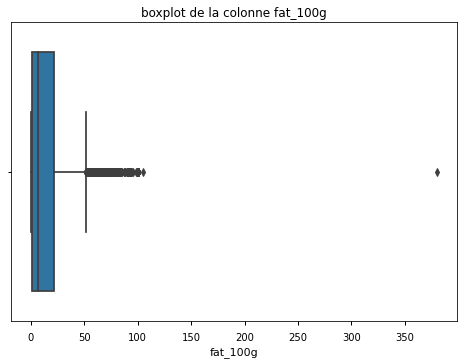

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


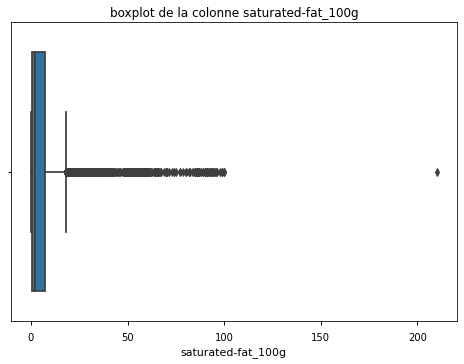

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


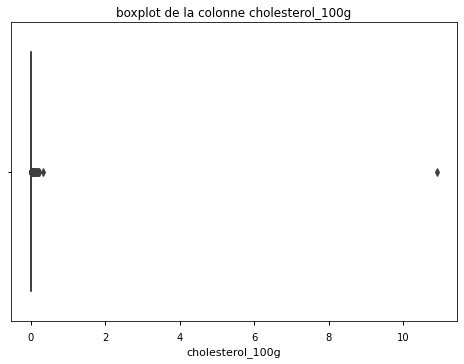

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


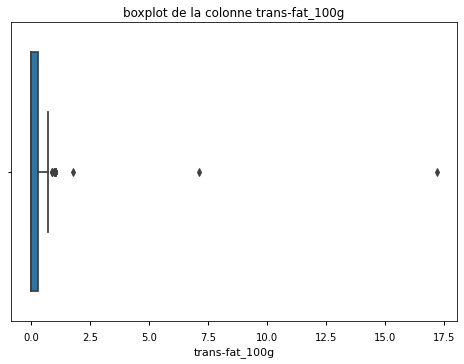

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


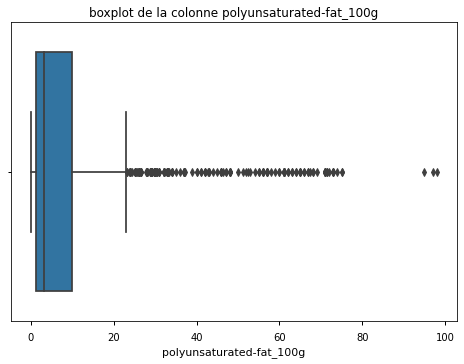

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


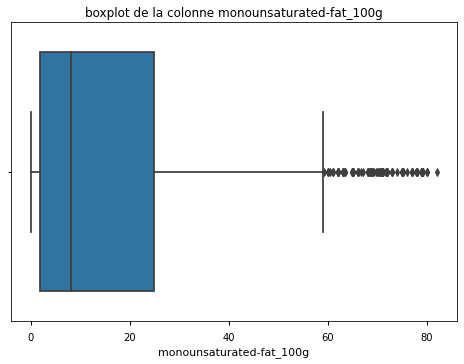

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


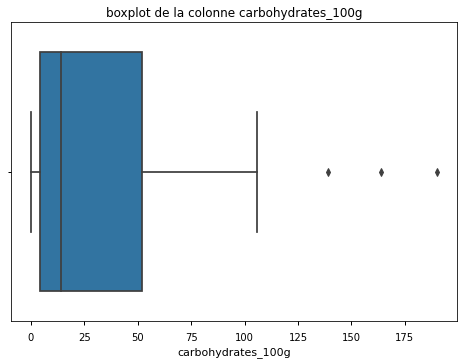

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


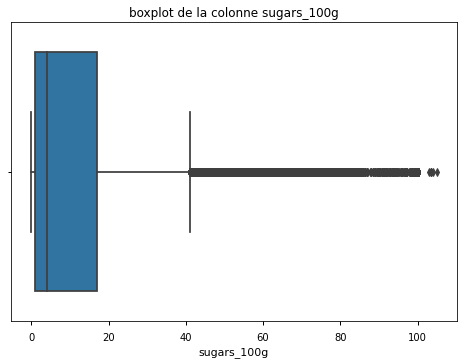

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


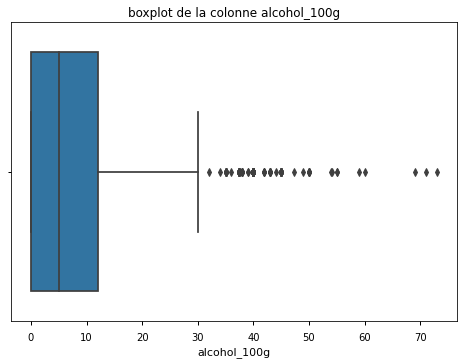

In [96]:
for composition in columns_numeric_selected :
    make_boxplot(df_categories_without_nan, composition)

Il semblerait que je peux enlver toutes les valeurs supérieures à 100 et que la médiane soit la plus adaptée

In [97]:
for composition in columns_numeric_selected :
    df_categories_without_nan.loc[df_categories_without_nan[composition]>=100, composition] = np.nan

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


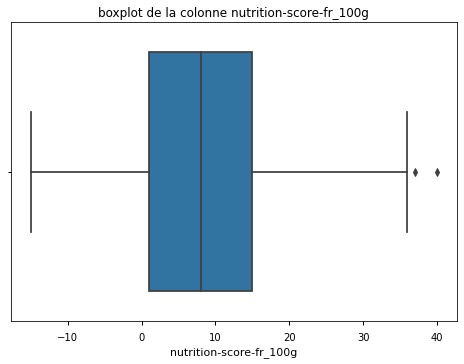

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


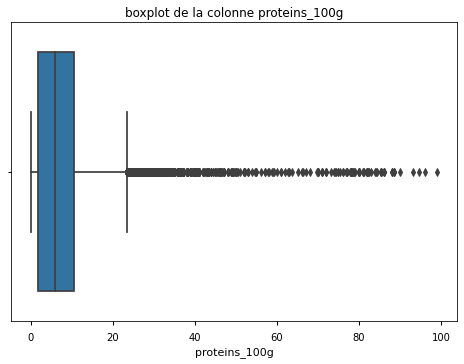

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


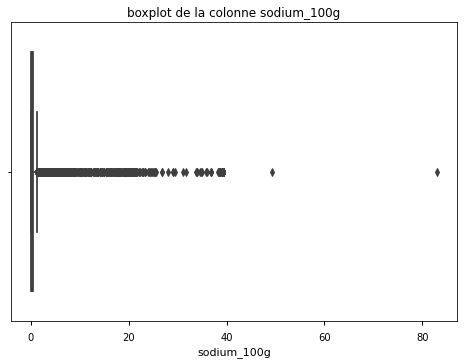

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


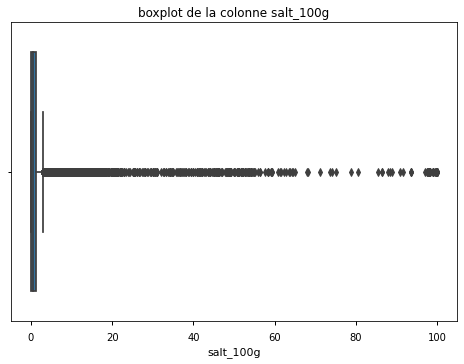

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


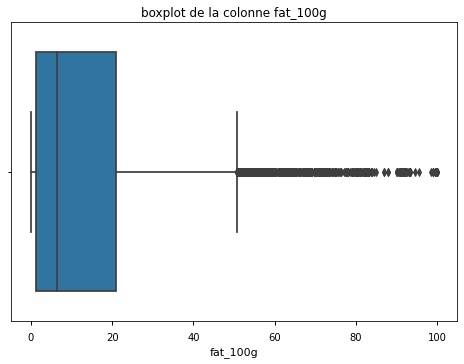

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


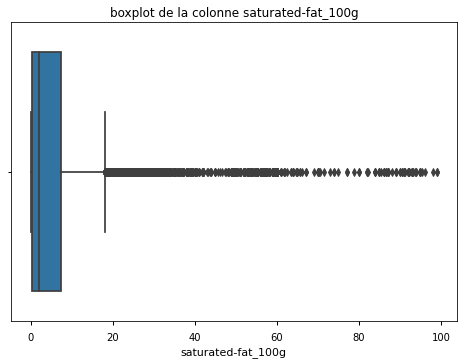

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


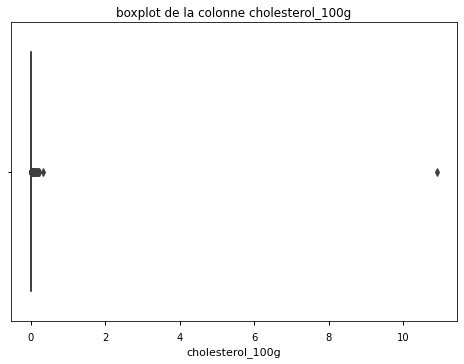

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


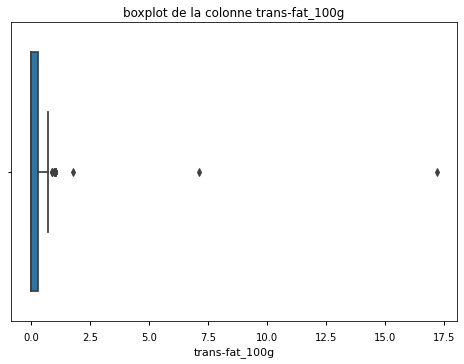

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


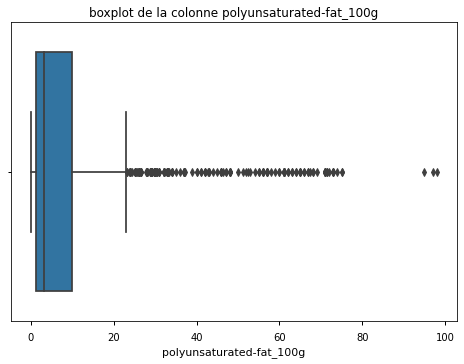

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


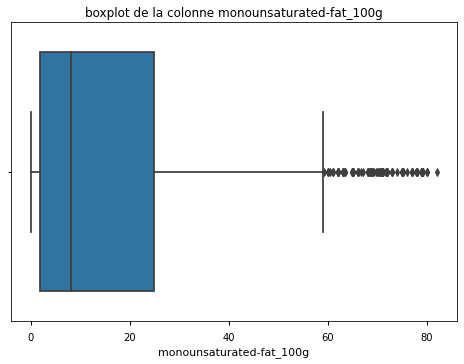

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


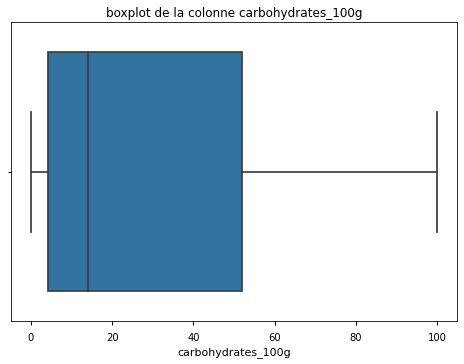

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


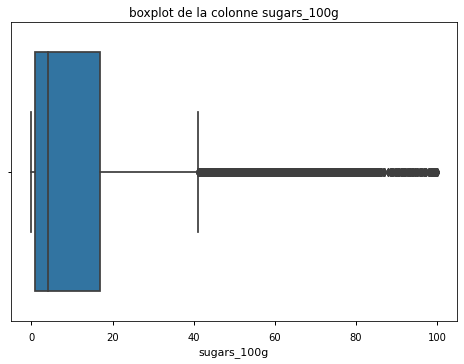

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


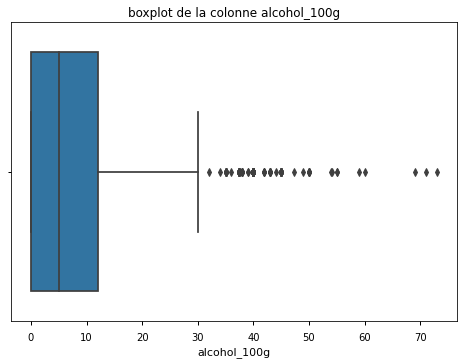

In [98]:
for composition in columns_numeric_selected :
    make_boxplot(df_categories_without_nan, composition)

## Build a median df par catégorie

In [99]:
# créer un dataset des moyennes des variables numériques par catégories
df_median_cat = df_categories_without_nan.groupby('main_category_stemmed', as_index=True).agg(np.nanmedian)[columns_numeric_selected]

In [100]:
df_median_cat.head()

,nutrition-score-fr_100g,proteins_100g,sodium_100g,salt_100g,fat_100g,saturated-fat_100g,cholesterol_100g,trans-fat_100g,polyunsaturated-fat_100g,monounsaturated-fat_100g,carbohydrates_100g,sugars_100g,alcohol_100g
main_category_stemmed,,,,,,,,,,,,,
appl juic,4.0,0.1,0.003937,0.01000,0.1,0.00,NaN,NaN,NaN,NaN,11.0,10.4,0.0
babi food,0.0,2.7,0.038000,0.09652,2.2,0.60,NaN,0.0,0.6,1.45,10.7,5.3,0.0
bacon bit,20.0,17.0,0.984252,2.50000,20.0,7.80,NaN,NaN,NaN,NaN,0.7,0.7,NaN
beverag,9.0,0.4,0.011811,0.03000,0.1,0.03,0.00000,0.0,0.8,0.40,9.3,8.0,9.0
biscuit,20.0,6.6,0.216535,0.55000,21.0,10.50,0.00159,0.2,1.9,7.00,64.4,30.0,0.0


In [101]:
df_median_cat = df_median_cat.T

In [102]:
df_median_cat.isnull().sum(axis=1)

nutrition-score-fr_100g      0
proteins_100g                0
sodium_100g                  0
salt_100g                    0
fat_100g                     0
saturated-fat_100g           0
cholesterol_100g            53
trans-fat_100g              63
polyunsaturated-fat_100g    35
monounsaturated-fat_100g    35
carbohydrates_100g           0
sugars_100g                  0
alcohol_100g                15
dtype: int64

In [103]:
# j'enleve les colonnes ayant des valeurs nulles -> trop de nan pour être pertinente. Pour alcool, il faudrait creuser la catégorie beverage qui contient des alcools et des soft..
df_median_cat = df_median_cat.T
df_median_cat.drop(columns=['cholesterol_100g', 'trans-fat_100g', 'polyunsaturated-fat_100g', 
                            'monounsaturated-fat_100g', 'alcohol_100g'], inplace=True)
df_median_cat = df_median_cat.T

In [104]:
df_categories_without_nan.drop(columns=['cholesterol_100g', 'trans-fat_100g', 'polyunsaturated-fat_100g', 
                            'monounsaturated-fat_100g', 'alcohol_100g', 'main_category_lemmatize'], inplace=True)
df_categories_without_nan.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88292 entries, 8 to 43438
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   code                     88292 non-null  object 
 1   product_name             88292 non-null  object 
 2   main_category_fr         88292 non-null  object 
 3   main_category            70831 non-null  object 
 4   nutrition_grade_fr       66549 non-null  object 
 5   countries_fr             88292 non-null  object 
 6   ingredients_text         63692 non-null  object 
 7   nutrition-score-fr_100g  66549 non-null  float64
 8   proteins_100g            70929 non-null  float64
 9   sodium_100g              68191 non-null  float64
 10  salt_100g                68196 non-null  float64
 11  fat_100g                 57945 non-null  float64
 12  saturated-fat_100g       67877 non-null  float64
 13  carbohydrates_100g       57717 non-null  float64
 14  sugars_100g           

In [105]:
columns_numeric_selected.remove('trans-fat_100g')
columns_numeric_selected.remove('polyunsaturated-fat_100g')
columns_numeric_selected.remove('monounsaturated-fat_100g')
columns_numeric_selected.remove('cholesterol_100g')
columns_numeric_selected.remove('alcohol_100g')

In [106]:
final_selection = df_categories_without_nan
len(final_selection)

88292

In [107]:
df_median_cat.head(5)

main_category_stemmed,appl juic,babi food,bacon bit,beverag,biscuit,bread,bread product,breakfast,butter,cake,...,tuna,veget oil,veget rod,vinegar,waffl,water,wheat flour,white chees,whole milk yogurt,yogurt
nutrition-score-fr_100g,4.000000,0.00000,20.000000,9.000000,20.000000,1.000000,3.000000,9.0000,19.00000,17.000000,...,1.000000,12.0,-4.000000,5.000000,22.000000,1.00000,-6.000000,0.00000,3.000000,2.000000
proteins_100g,0.100000,2.70000,17.000000,0.400000,6.600000,9.300000,12.500000,8.1000,0.70000,5.600000,...,25.000000,0.0,1.800000,0.500000,6.000000,0.00000,10.600000,6.80000,3.500000,3.900000
sodium_100g,0.003937,0.03800,0.984252,0.011811,0.216535,0.472441,0.472441,0.1400,0.03937,0.216535,...,0.400787,0.0,0.309055,0.015748,0.178583,0.00300,0.003937,0.03937,0.043307,0.047244
salt_100g,0.010000,0.09652,2.500000,0.030000,0.550000,1.200000,1.200000,0.3556,0.10000,0.550000,...,1.016000,0.0,0.785000,0.040000,0.453600,0.00762,0.010000,0.10000,0.110000,0.120000
fat_100g,0.100000,2.20000,20.000000,0.100000,21.000000,4.700000,10.000000,7.6750,82.00000,21.000000,...,3.100000,92.0,0.300000,0.000000,24.800000,0.00000,1.200000,3.20000,3.145000,3.000000


In [108]:
final_selection=final_selection.reset_index()
final_selection.head(2)

,index,code,product_name,main_category_fr,main_category,nutrition_grade_fr,countries_fr,ingredients_text,nutrition-score-fr_100g,proteins_100g,sodium_100g,salt_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,product_name_original,main_category_stemmed,product_name_clean
0,8,1071894,Flute,Pains,[breads],NaN,Royaume-Uni,Wheat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flute,bread,flute
1,11,5200016,green lentils,Aliments et boissons à base de végétaux,"[plant, based, foods, beverages]",NaN,France,lentilles vertes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lentilles vertes,plant base food beverag,green lentil


In [109]:
for compo in columns_numeric_selected:
    for categorie in (final_selection['main_category_stemmed'].unique()):
        value=df_median_cat[categorie].loc[compo]
        selected_cat = final_selection[final_selection['main_category_stemmed']==categorie]
        selected_cat.loc[selected_cat[compo].isna(), compo]=value
        #selected_cat.loc[:,compo]=selected_cat.loc[:,compo].fillna(value=value)
        #selected_cat[compo].fillna(value=value,inplace=True)
        final_selection.loc[list(final_selection.loc[final_selection[
                    'main_category_stemmed']==categorie].index), compo]=selected_cat[compo]

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [110]:
final_selection['nutrition-score-fr_100g'].isnull().sum()

0

In [111]:
final_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88292 entries, 0 to 88291
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    88292 non-null  int64  
 1   code                     88292 non-null  object 
 2   product_name             88292 non-null  object 
 3   main_category_fr         88292 non-null  object 
 4   main_category            70831 non-null  object 
 5   nutrition_grade_fr       66549 non-null  object 
 6   countries_fr             88292 non-null  object 
 7   ingredients_text         63692 non-null  object 
 8   nutrition-score-fr_100g  88292 non-null  float64
 9   proteins_100g            88292 non-null  float64
 10  sodium_100g              88292 non-null  float64
 11  salt_100g                88292 non-null  float64
 12  fat_100g                 88292 non-null  float64
 13  saturated-fat_100g       88292 non-null  float64
 14  carbohydrates_100g    

In [112]:
final_selection.to_csv('./dataset_for_analysis.csv')

# Analyse des features

## corrélation au nutriscore

<AxesSubplot:>

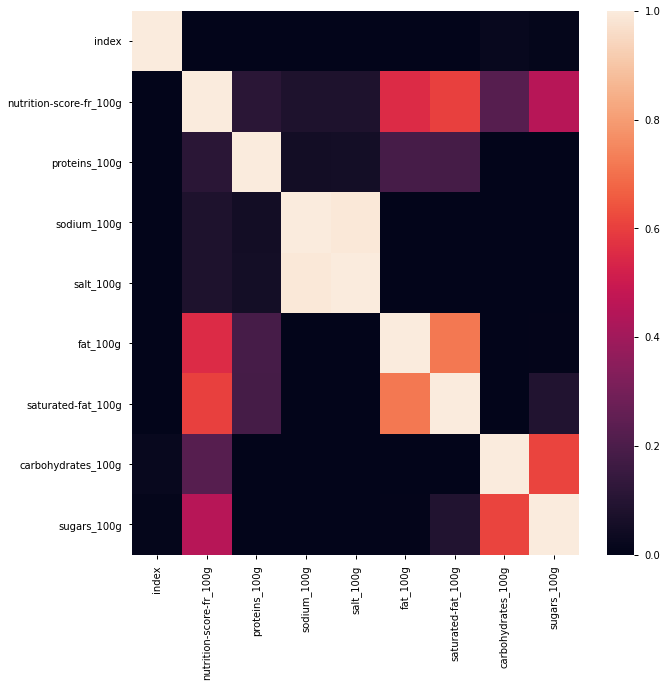

In [113]:
plt.figure(figsize=(10,10))
sns.heatmap(final_selection.corr(),  vmin=0, vmax=1)

On voit que les élements les plus corrélés au nutriscore sont la gaisse, les graisses saturés, les carbonydrates et le sugre

In [114]:
print('corrélation fat satured fat')
print(final_selection['saturated-fat_100g'].corr(final_selection['fat_100g']))

corrélation fat satured fat
0.7171627194991519


In [115]:
print('correlation sucre et carbonhydrate')
print(final_selection['sugars_100g'].corr(final_selection['carbohydrates_100g']))

correlation sucre et carbonhydrate
0.6097008904265836


In [116]:
print('correlation sodium et sel')
print(final_selection['sodium_100g'].corr(final_selection['salt_100g']))

correlation sodium et sel
0.9904336191555114


In [117]:
final_selection.drop(columns='sodium_100g', inplace=True)

In [118]:
columns_numeric_selected.remove('sodium_100g')

## Anova

Hypothese :
- H0 : Le pays d'origine n'influe pas sur le nutriscore moyen
- H1 : le pays influ sur le nutriscore\
alpha = 0.05


In [119]:
colonnes_anova = ['countries_fr', 'nutrition-score-fr_100g']
selection_test_anova = final_selection[colonnes_anova]
selection_test_anova.dropna()
print(selection_test_anova.shape)
selection_test_anova.head(2)

(88292, 2)


,countries_fr,nutrition-score-fr_100g
0,Royaume-Uni,1.0
1,France,0.0


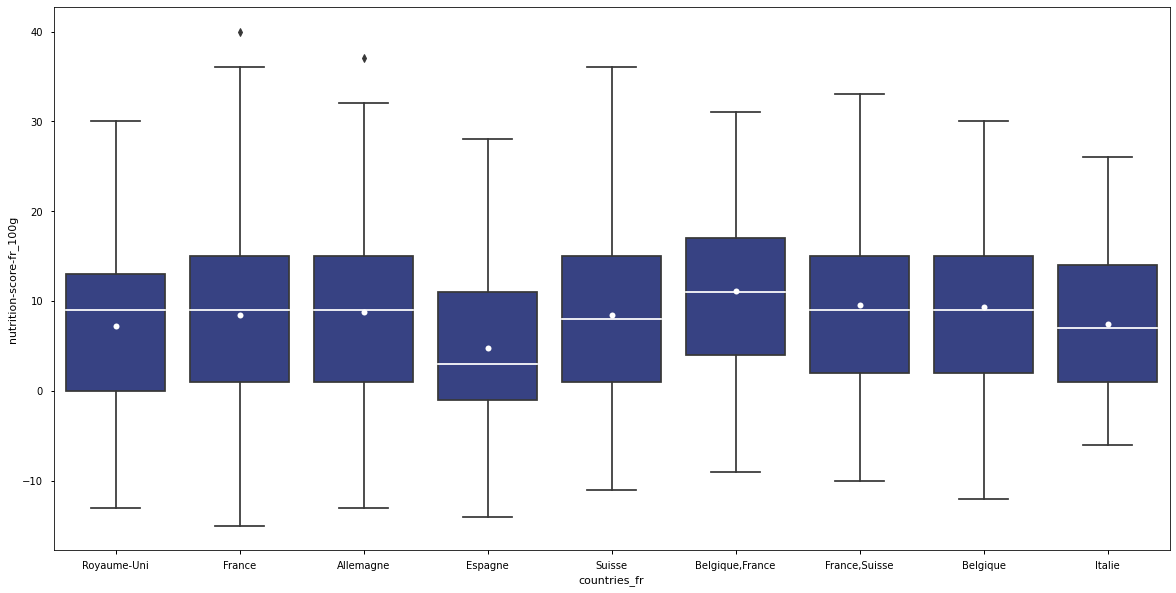

In [120]:
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'white'}
medianprops = {'color':"white"}
plt.figure(figsize=(20,10))
ax = sns.boxplot(x='countries_fr', y='nutrition-score-fr_100g', data=selection_test_anova, color='#2a3990',
                meanprops=meanprops, showmeans=True, medianprops=medianprops)

In [121]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

selection_test_anova=selection_test_anova.rename(columns={'countries_fr':'countries_fr', 'nutrition-score-fr_100g':'nutrition_score_fr_100g'})

# ANOVA Test 
model = ols('nutrition_score_fr_100g ~ countries_fr', data=selection_test_anova).fit()
anova = sm.stats.anova_lm(model, typ=2)

anova

,sum_sq,df,F,PR(>F)
countries_fr,5.705543e+04,8.0,97.750701,8.464597e-163
Residual,6.441161e+06,88283.0,NaN,NaN


La p value étant très largement inferieur à 0.05 et la F stat etant grande (significatif), on peut rejetter h0 et adopter h1 : le pays influ sur le nutriscore.

## pca

### fonctions pca

In [122]:
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()



### pca analysis

In [123]:
from sklearn import decomposition, preprocessing
from sklearn.preprocessing import StandardScaler
N_COMP=6

In [124]:
X=final_selection[columns_numeric_selected].values
features = final_selection[columns_numeric_selected].columns

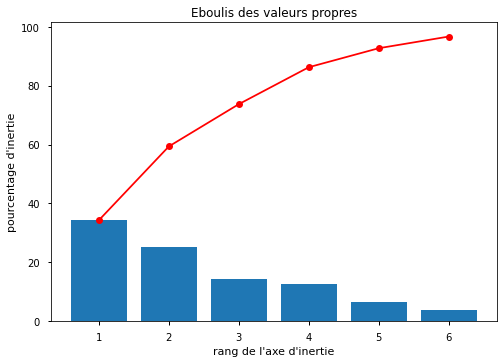

In [125]:
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
pca=decomposition.PCA(n_components=N_COMP)
pca.fit(X_scaled)
display_scree_plot(pca)

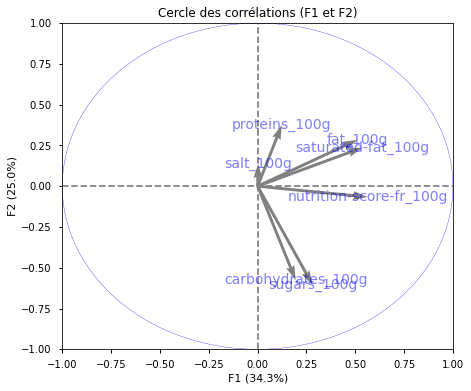

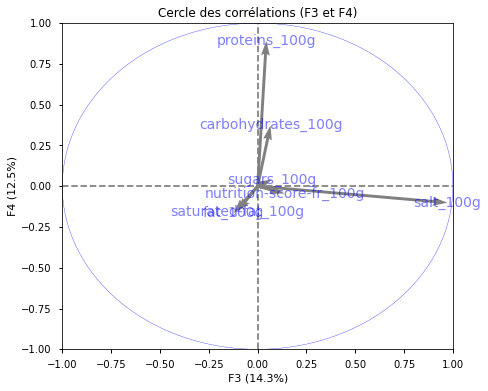

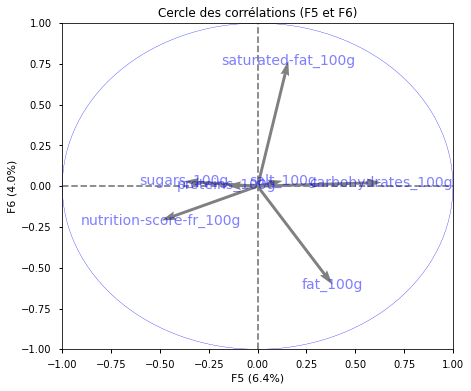

In [126]:
pcs=pca.components_
display_circles(pcs, N_COMP, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))

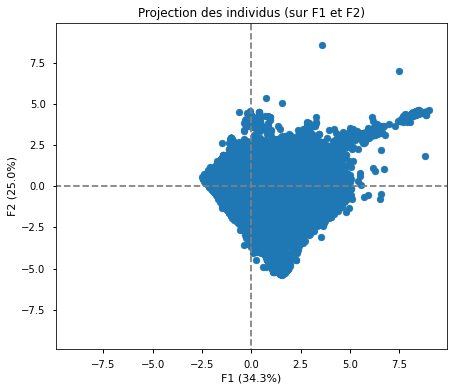

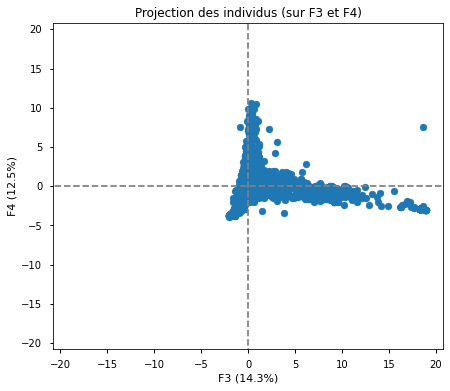

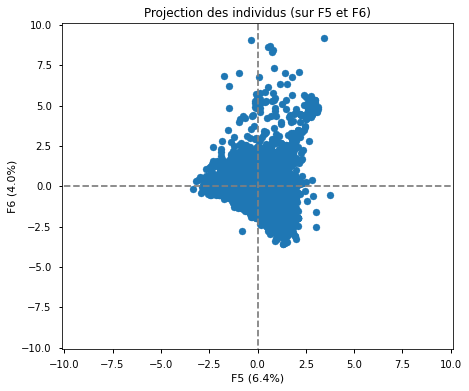

In [127]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, N_COMP, pca, [(0,1),(2,3),(4,5)],)# labels = np.array(names))

plt.show()

# Calcul Scores

In [128]:
def assigne_score(row, q1, q2, q3, q4):
    if row<q1:
        return 1
    elif row>=q1 and row<q2 :
        return 2
    elif row>=q2 and row<q3 :
        return 3
    elif row>=q2 and row<q3 :
        return 4
    else : 
        return 5

def score_attractivite(selection_data, composant):
    '''
    Prend data et un indicateur
    Classe la donnée puis met uns score dattractivité selon IQ
    :q1 -> 1 | q1:q2 -> 2 | q2:q3 -> 3 | q3:q4 -> 4 | q4: -> 5
    '''
    selection_data = selection_data.sort_values(by=composant)
    q1 = selection_data[composant].quantile(.20)
    q2 = selection_data[composant].quantile(.40)
    q3 = selection_data[composant].quantile(.60)
    q4 = selection_data[composant].quantile(.80)
    
    selection_data[f'{composant}_score'] = selection_data[
        composant].apply(lambda x : assigne_score(x, q1, q2, q3, q4))
    return selection_data

In [129]:
for compo in columns_numeric_selected:
    final_selection=score_attractivite(final_selection, compo)

In [130]:
final_selection.columns

Index(['index', 'code', 'product_name', 'main_category_fr', 'main_category',
       'nutrition_grade_fr', 'countries_fr', 'ingredients_text',
       'nutrition-score-fr_100g', 'proteins_100g', 'salt_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'product_name_original', 'main_category_stemmed', 'product_name_clean',
       'nutrition-score-fr_100g_score', 'proteins_100g_score',
       'salt_100g_score', 'fat_100g_score', 'saturated-fat_100g_score',
       'carbohydrates_100g_score', 'sugars_100g_score'],
      dtype='object')

In [131]:
final_selection_ = final_selection[['code', 'main_category_stemmed', 'main_category_fr',
                                   'nutrition-score-fr_100g_score','product_name_original','nutrition_grade_fr',
                                     'salt_100g_score','product_name_clean',
                                   'fat_100g_score', 'saturated-fat_100g_score', 
                                   'sugars_100g_score', 'carbohydrates_100g_score']]


In [132]:
final_selection_ = final_selection_.rename(
    columns={'code': 'code', 'product_name_original':'product_name', 
            'main_category_stemmed':'main_category_stemmed', 'nutrition-score-fr_100g_score': 'nutri_score',
       'salt_100g_score': 'salt_score', 'fat_100g_score':'lipide_score', 'saturated-fat_100g_score':'satured_fat_score', 
       'sugars_100g_score': 'sucre_score', 'carbohydrates_100g_score': 'gluci_score'})

In [133]:
final_selection_.columns

Index(['code', 'main_category_stemmed', 'main_category_fr', 'nutri_score',
       'product_name', 'nutrition_grade_fr', 'salt_score',
       'product_name_clean', 'lipide_score', 'satured_fat_score',
       'sucre_score', 'gluci_score'],
      dtype='object')

In [134]:
final_selection_.shape

(88292, 12)

In [135]:
final_selection_[final_selection_.main_category_stemmed=='biscuit'].sort_values('nutri_score')

,code,main_category_stemmed,main_category_fr,nutri_score,product_name,nutrition_grade_fr,salt_score,product_name_clean,lipide_score,satured_fat_score,sucre_score,gluci_score
36248,3423720001145,biscuit,Biscuits,1,Biscuit Nature et Bienfaits - Épeautre et abri...,a,3,natur benefit spell apricot biscuit,5,1,3,5
36249,3423720001152,biscuit,Biscuits,1,Biscuits Nature & Bienfaits - 100% Végétal - S...,a,3,natur benefit biscuit plant base without yeast...,5,2,3,5
73542,3229820794631,biscuit,biscuit,1,Galettes 4 Cereales,a,3,cooki cereal,5,2,2,5
77708,3560070379057,biscuit,biscuit,1,"8 Palets Aux Petits Légumes, 300 Grammes, Marq...",a,5,palet small veget gram carrefour brand,5,3,3,5
16789,3229820786544,biscuit,Biscuits,1,Biscuits de Son d'Avoine au Cacao,a,3,cocoa oat bran cooki,5,3,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...
43407,3564707083744,biscuit,Biscuits,5,Biscuits nappés chocolat au lait,e,3,milk chocol coat cooki,5,5,5,5
69249,8710434091094,biscuit,Biscuits,5,Original Dutch Cookies,e,5,origin dutch cooki,5,5,5,5
43176,3564700743843,biscuit,Biscuits,5,Deli Matin les Généreux goûr Chocolat Noisette,d,5,deli matin gener chocol hazelnut flavor,5,5,5,5
63044,7617400037401,biscuit,Biscuits,5,Zitronenherzli,d,3,lemon heart,5,5,5,5


In [136]:
#je rempli les product_name par la catégorie si il n'y a pas de catégorie
final_selection_['product_name'].fillna(value=final_selection_['main_category_stemmed'], inplace=True)

In [137]:
df_mean_scores = final_selection_.groupby('main_category_stemmed', as_index=False).mean()

In [138]:
df_mean_scores.to_csv('./data_mean_scores.csv')

In [139]:
final_selection_.to_csv('./data_clean_score.csv', index=True)

In [140]:
df_median_cat.to_csv('./data_median_compo.csv', index=True)

In [141]:
final_selection_[final_selection_['product_name'].isna()]

,code,main_category_stemmed,main_category_fr,nutri_score,product_name,nutrition_grade_fr,salt_score,product_name_clean,lipide_score,satured_fat_score,sucre_score,gluci_score
